In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

### Set up FLC Index

In [2]:
data_root = "/home/jturner/false_low_clouds_2023/Model/Model_flc_v2_data/"

In [3]:
time="00z"

date="20230907"

Import the GFS and SST data

*capture just withholds the output*

In [4]:
%%capture
gfs_file = data_root+"time_"+time+"/"+date+"/gfs.t"+time+".pgrb2.0p25.f000"

gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib", backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

In [5]:
sst_file = data_root+"time_"+time+"/"+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

Filter the datasets to the region of interest

In [6]:
#---Georges Bank
# min_lon = -71.5
# min_lat = 37
# max_lon = -64
# max_lat = 42.5

min_lon = -70.5
min_lat = 39
max_lon = -67
max_lat = 43

In [7]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon+360,max_lon+360))

#--- GFS data latitude is reversed compared to the SST data, this flips it into position.
gfs_ds = gfs_ds.sel(latitude=slice(None, None, -1))

gfs_ds = gfs_ds.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))

For atmospheric temperature, use from the level of most humidity

Identify the indices where the maximum humidity occurs for each height level

In [8]:
max_humidity_indices = gfs_ds['q'].argmax(dim='isobaricInhPa')

Use these indices to filter the temperature data

In [9]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = gfs_ds.t.values[0][0:begin,0:end]

In [10]:
#---For some bizarre reason, this initialization of T_maxq seems to be necessary
#---Another bizarre action is that this changes dims to a numpy array
T_maxq = np.zeros(dims.shape)
T_maxq = gfs_ds['t'].isel(isobaricInhPa=max_humidity_indices)

In [11]:
T_diff = T_maxq[0:begin,0:end].values - sst_ds.sst[:,:].values

In [12]:
np.shape(T_diff)

(16, 14)

### Set up NLCT

In [13]:
date = "20230907"
hour = "06"

nlct_path = "/mnt/data2/jturner/nlct_data/georges_bank/"+date+"/"

In [14]:
filename = 'goes_e_ntlc_'+date[0:4]+'_'+date[4:6]+'_'+date[6:8]+'_'+hour+'H_00M.nc'

BTD = xr.open_dataset(nlct_path+filename)

In [15]:
BTD

<xarray.Dataset>
Dimensions:                        (time: 1, y: 144, x: 156)
Coordinates:
  * time                           (time) datetime64[ns] 2023-09-07T06:00:00
    y_image                        float32 ...
    x_image                        float32 ...
  * y                              (y) float64 0.1148 0.1148 ... 0.1069 0.1068
  * x                              (x) float64 0.009716 0.009772 ... 0.0184
    lat                            (y, x) float64 ...
    lon                            (y, x) float64 ...
Data variables:
    __xarray_dataarray_variable__  (time, y, x) float32 ...

### Comparison between images

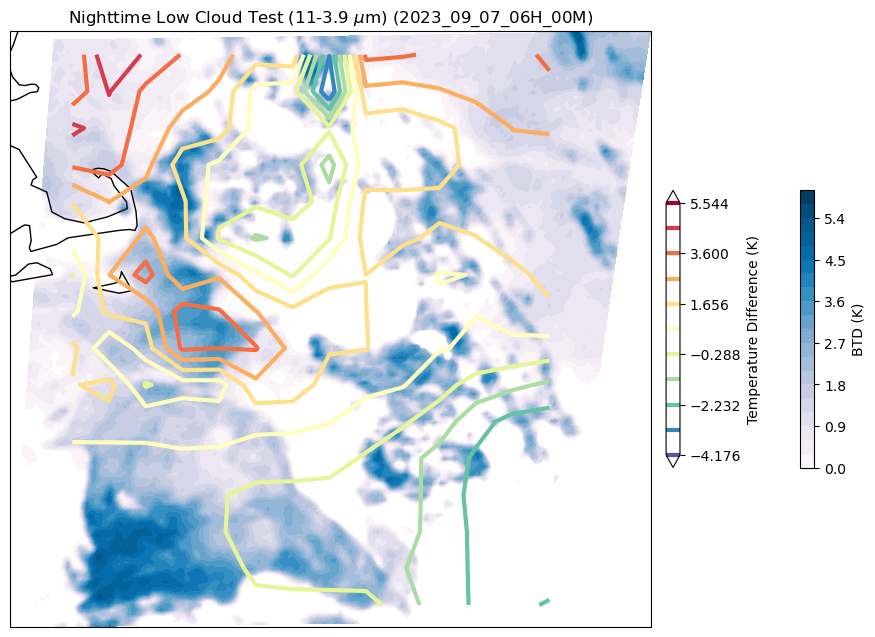

In [16]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap_nlct = plt.cm.PuBu
cmap_flci = plt.cm.Spectral_r
levels_nlct = np.linspace(0, 6, 21)
levels_flci = np.linspace(np.nanmin(T_diff), np.nanmax(T_diff), 11)

nlct=ax.contourf(BTD.lon, BTD.lat, BTD.__xarray_dataarray_variable__[0], cmap=cmap_nlct, extend='neither', levels=levels_nlct, alpha=1)
flci=ax.contour(sst_ds.lon, sst_ds.lat, T_diff, cmap=cmap_flci, extend='both', levels=levels_flci, alpha=1, linewidths=3)

clb_nlct=plt.colorbar(nlct, shrink=0.3, pad=0.02, ax=ax)
clb_flci=plt.colorbar(flci, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Nighttime Low Cloud Test (11-3.9 $\mu$m) ('+filename[12:30]+')')
clb_nlct.set_label('BTD (K)')
clb_flci.set_label('Temperature Difference (K)')

ax.coastlines(resolution='50m', color='black', linewidth=1)

### Nearest neighbors

For each FLCI point, I want to find the nearest NLCT point. Collect the temperature difference and the BTD. 

In [17]:
from scipy.spatial import cKDTree

In [18]:
# Convert latitude and longitude to 1D arrays
flci_lat, flci_lon = np.ravel(sst_ds.lat), np.ravel(sst_ds.lon)
nlct_lat, nlct_lon = np.ravel(BTD.lat), np.ravel(BTD.lon)

In [19]:
# Create KDTree for the first dataset
tree_ds1 = cKDTree(list(zip(flci_lat, flci_lon)))

In [20]:
# Query the KDTree for the closest points in the second dataset
distances, indices = tree_ds1.query(list(zip(nlct_lat, nlct_lon)))

In [21]:
# Get the corresponding lat/lon pairs in the first dataset
closest_latlon_ds1 = list(zip(flci_lat[indices], flci_lon[indices]))

In [22]:
print("Closest lat/lon pairs:", closest_latlon_ds1)
print("Distances:", distances)

Closest lat/lon pairs: [(39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125, 289.625), (39.125